In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import glob
import os
import geopandas as gpd

# Initial Visualization: Time series of Yield

In [4]:
results = pd.read_parquet("/workspace/workflow/_6EvaluationNotebooks/results.parquet", engine="fastparquet")

In [5]:
results["Clock.Today"] = pd.to_datetime(results["Clock.Today"])


possible_vars = ['MaizeYield','SoyBeanYield','Yield','Nitrogen_Sowing']

@interact(variable=possible_vars)
def plot_variable(variable="SurfaceOrganicMatter.Cover"):
    pivot_df = results.pivot_table(
        index="Clock.Today",
        columns="Nitrogen",
        values=variable,
        aggfunc="mean"  # Puedes usar "first" o "sum" según el caso
    )

    plt.figure(figsize=(12, 6))
    for col in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[col], label=f"Nitrogen {col}")

    plt.xlabel("Date")
    plt.ylabel("Yield")
    plt.title(f"{"SurfaceOrganicMatter.Cover"} over time")
    plt.legend(title="Simulation", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()




interactive(children=(Dropdown(description='variable', options=('MaizeYield', 'SoyBeanYield', 'Yield', 'Nitrog…

# GTD - Ground Truth Data

In [20]:
GTD=pd.read_csv("/workspace/workflow/_6EvaluationNotebooks/GTD.csv")


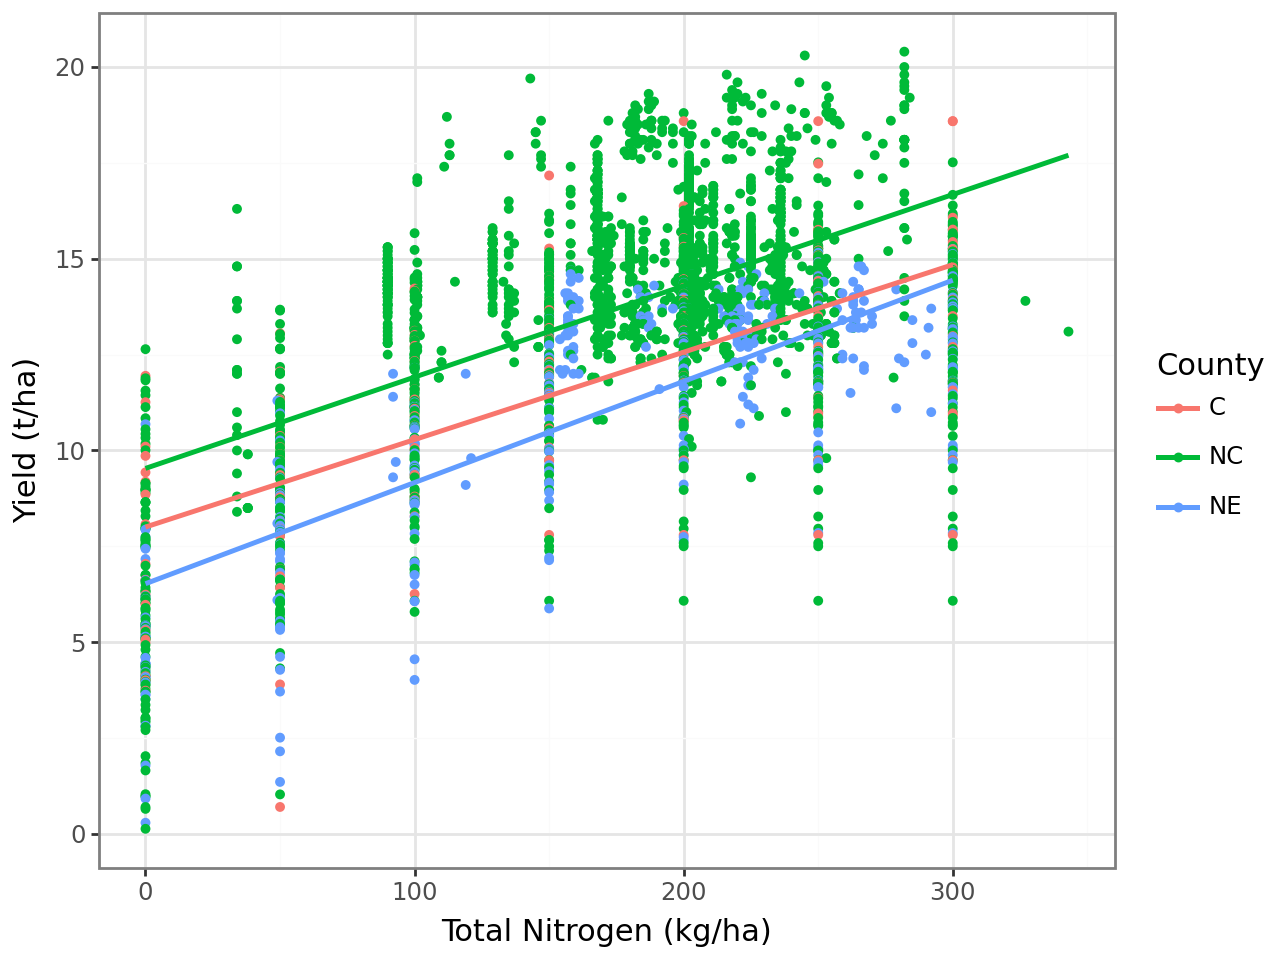

In [21]:
from plotnine import ggplot, aes, geom_point, geom_smooth, labs, theme_bw

plot = (
    ggplot(GTD, aes(x='NKg_Ha', y='yield_ton', color='region')) +
    geom_point(size=1) +
    geom_smooth(method='lm', se=False) +
    theme_bw() +
    labs(
        x='Total Nitrogen (kg/ha)',
        y='Yield (t/ha)',
        color='County'
    )
)

plot.show()

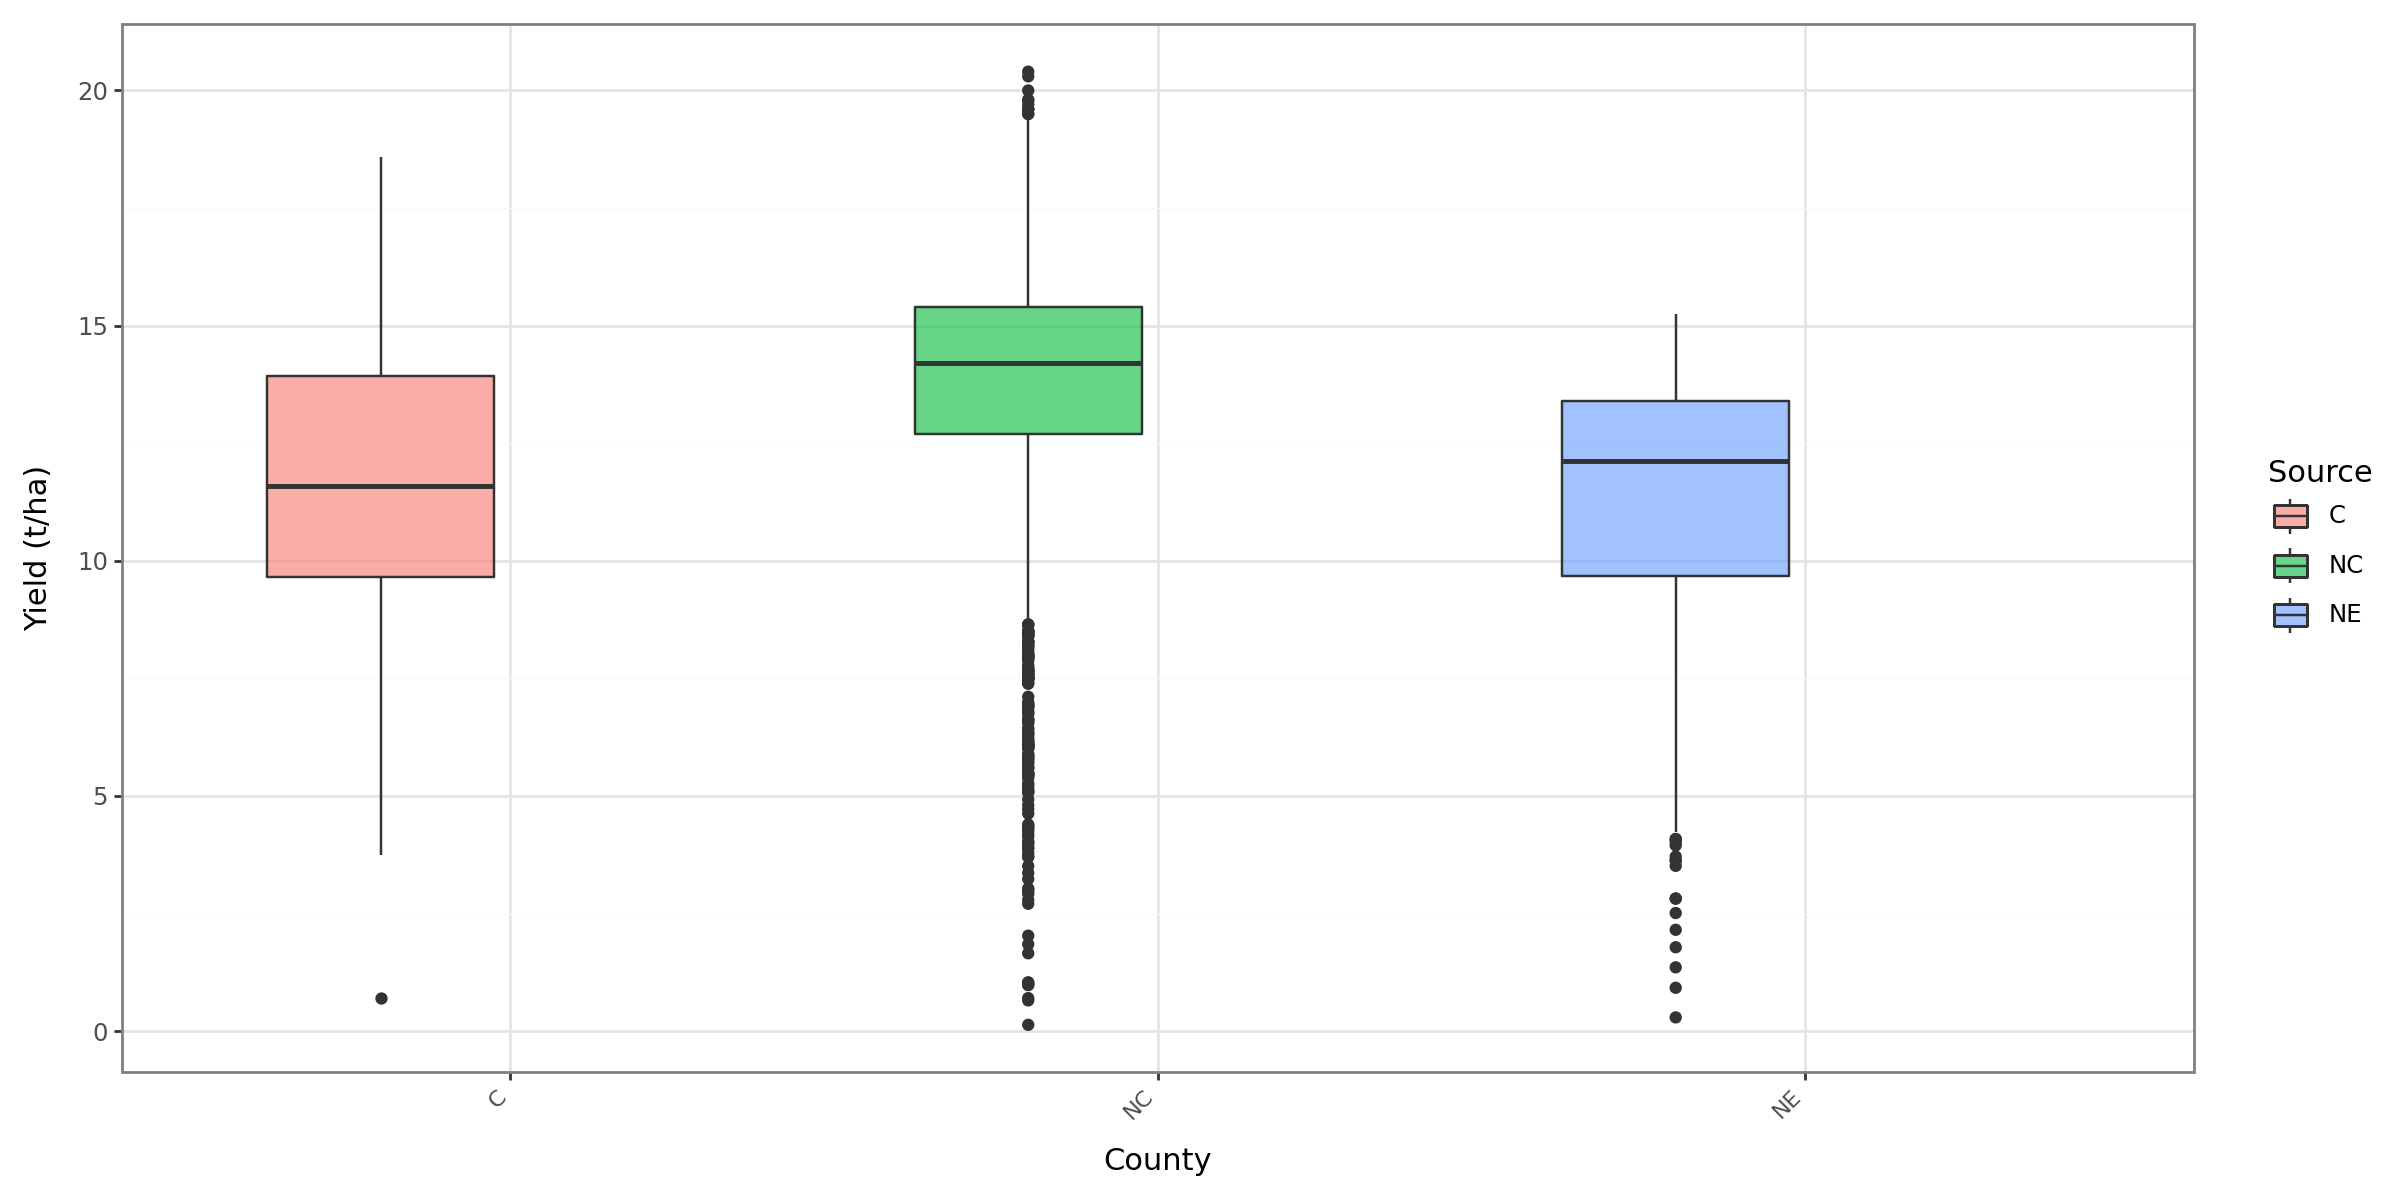

In [22]:
from plotnine import *
plot = (
    ggplot() +
    # Boxplots de valores observados
    geom_boxplot(
        data=GTD,
        mapping=aes(x='region', y='yield_ton', fill="region"),
        position=position_nudge(x=-0.2),
        width=0.35,
        alpha=0.6
    ) +
    theme_bw() +
    labs(
        x='County',
        y='Yield (t/ha)',
        fill='Source'
    )+
    theme(
        axis_text_x=element_text(size=8, angle=45, hjust=1),  # 🔹 tamaño y rotación
        figure_size=(12, 6)  # 🔹 hace el gráfico más ancho directamente
    )
)

plot.show()

# Comparation

In [23]:
# Loading fields 

folder = "/workspace/workflow/_3AgroDataExtraction"
geojson_file = glob.glob(os.path.join(folder, "*.geojson"))
fields=gpd.read_file(geojson_file[0])
fields_region=fields[['id_cell','id_within_cell','region']]
fields_region_indexed = fields_region.set_index(['id_cell', 'id_within_cell'])

results['Yield'] = (results['MaizeYield']+results['SoyBeanYield'])/1000
results = results[['Clock.Today','Yield','Nitrogen','id_cell','id_within_cell']]
results_region = results.join(fields_region_indexed, on=['id_cell', 'id_within_cell'])

results_region

,Clock.Today,Yield,Nitrogen,id_cell,id_within_cell,region
0,2006-07-31,0.078113,320,0,2,NC
1,2006-08-01,0.161217,320,0,2,NC
2,2006-08-02,0.248708,320,0,2,NC
3,2006-08-03,0.344826,320,0,2,NC
4,2006-08-04,0.441643,320,0,2,NC
...,...,...,...,...,...,...
2756701,2023-12-22,2.114084,360,1300,1,NE
2756702,2023-12-23,2.114084,360,1300,1,NE
2756703,2023-12-24,2.114084,360,1300,1,NE
2756704,2023-12-25,2.114084,360,1300,1,NE


Merging Dataframes

In [24]:
# Setting Dates
results_region['Clock.Today'] = pd.to_datetime(results_region['Clock.Today'])
results_region['Year'] = results_region['Clock.Today'].dt.year

# Selecting the max yield per year
idx = results_region.groupby(['Year', 'id_cell', 'id_within_cell','Nitrogen'])['Yield'].idxmax()
highest_yield = results_region.loc[idx].reset_index(drop=True)

# Deleting years 2019 and 2020 (No have GTD for thes years)
mask_c= (highest_yield['region'] == 'C') & (highest_yield['Year'] < 2014)
mask_other= (highest_yield['region'] != 'C') & (highest_yield['Year'] < 2019)

mask_GTD=(GTD['year'] < 2019) 

highest_yield_filtered_c= highest_yield[mask_c]
highest_yield_filtered_other= highest_yield[mask_other]
highest_yield_filtered=highest_yield_filtered_c.merge(highest_yield_filtered_other,how='outer')
GTD_filtered = GTD[mask_GTD]

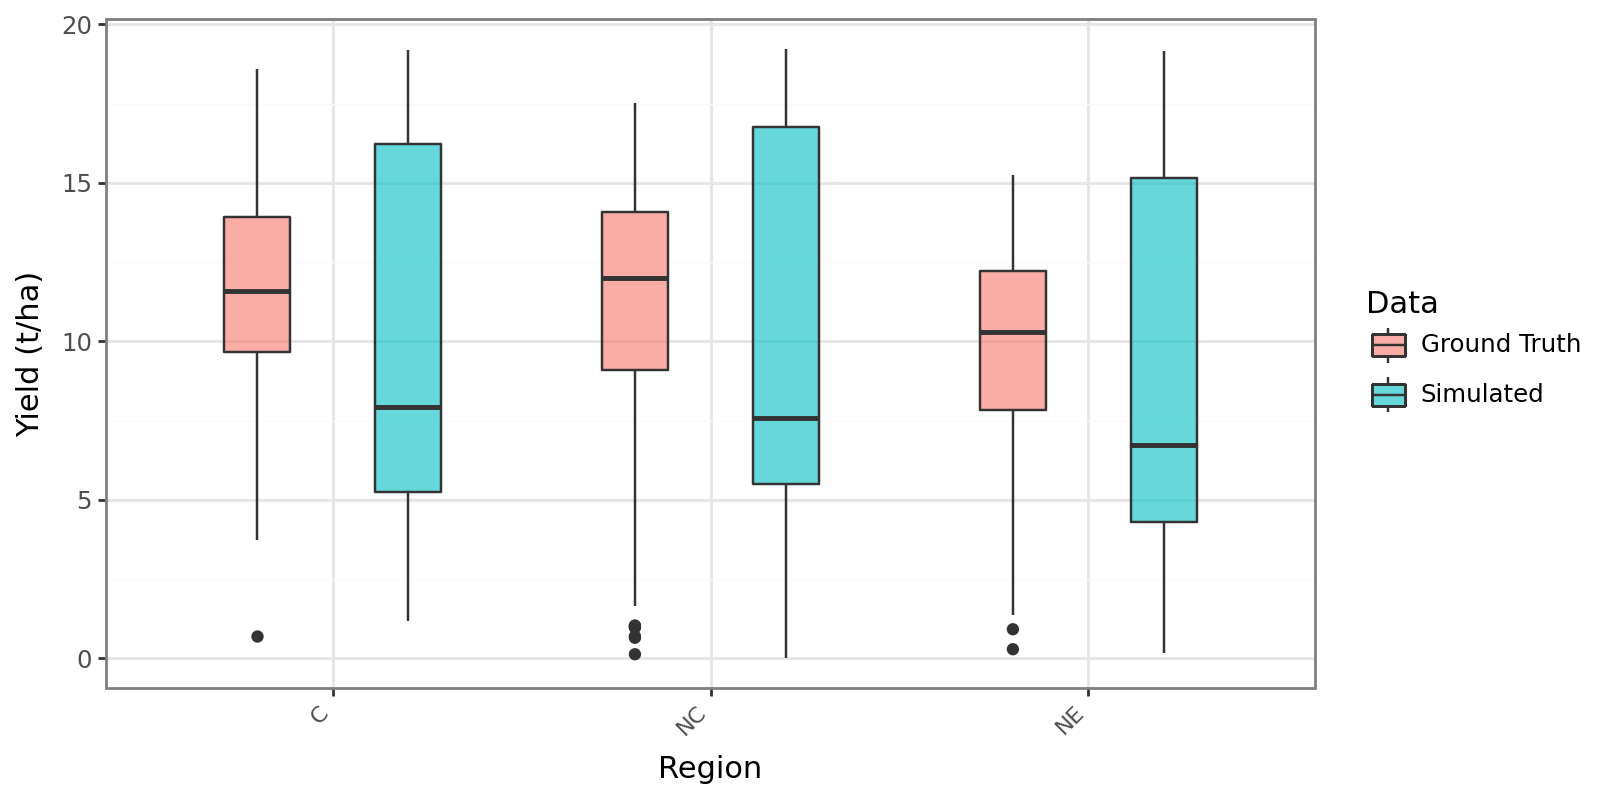

In [25]:
from plotnine import *

GTD_plot = GTD_filtered.copy()
GTD_plot['Yield'] = GTD_plot['yield_ton']  
GTD_plot['Source'] = 'Ground Truth'

highest_yield_plot = highest_yield_filtered.copy()
highest_yield_plot['Source'] = 'Simulated'

plot_data = pd.concat([GTD_plot, highest_yield_plot], axis=0)

plot = (
    ggplot(plot_data, aes(x='region', y='Yield', fill='Source')) +
    geom_boxplot(position=position_dodge(width=0.8), width=0.35, alpha=0.6) +
    theme_bw() +
    labs(
        x='Region',
        y='Yield (t/ha)',
        fill='Data'
    ) +
    theme(
        axis_text_x=element_text(size=8, angle=45, hjust=1),
        figure_size=(8, 4)
    )
)

plot.show()


In [ ]:
grouped_df = pd.DataFrame(highest_yield.groupby(['Nitrogen', 'region','id_cell','id_within_cell'])['Yield'].mean())
grouped_df = (
    highest_yield
        .groupby(['Nitrogen', 'region', 'id_cell', 'id_within_cell','Year'], as_index=False)
        .agg({'Yield': 'mean'})
)


In [31]:
grouped_df.to_csv('/workspace/workflow/_6EvaluationNotebooks/finaldata.csv',index=False)